In [1]:
from torch import nn, Tensor
import numpy as np
import math
import torch
import datetime
import pandas as pd
from sklearn.model_selection import train_test_split 
from Helpers import TST_model as tst
from Helpers import inference as infer 
from Helpers import other_classes as other
from Helpers import utils
from torch.utils.data import DataLoader

#from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
#import dataset as ds
#import transformer_timeseries as tst


c:\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#read_file = pd.read_csv (r'C:\Users\admitos\Desktop\household_power_consumption.txt')
#read_file.to_csv (r'C:\Users\admitos\Desktop\Ηousehold_power_consumption.csv', index=None)

aal_file = pd.read_csv(r'C:\Users\admitos\Desktop\Visual Studio Notebooks\Time Series Transformer\AAL_data.csv')
aap_file = pd.read_csv(r'C:\Users\admitos\Desktop\Visual Studio Notebooks\Time Series Transformer\AAP_data.csv')
aapl_file = pd.read_csv(r'C:\Users\admitos\Desktop\Visual Studio Notebooks\Time Series Transformer\AAPL_data.csv')

In [3]:
aal_data = aal_file.loc[:, aal_file.columns != 'Name']
aap_data = aap_file.loc[:, aap_file.columns != 'Name']
aapl_data = aapl_file.loc[:, aapl_file.columns != 'Name']

In [4]:
#read_file.loc[0]
#my_df = read_file['Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3'].str.split(';', n=9, expand=True)
#my_df.columns = ['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


In [6]:
def __init__(self, input_size: int, dec_seq_len: int, batch_first: bool, out_seq_len: int=58, dim_val: int=512, n_encoder_layers: int=4, n_heads: int=8,
        n_decoder_layers: int=4, dropout_encoder: float=0.2, dropout_decoder: float=0.2, dropout_pos_enc: float=0.1, dim_feedforward_encoder: int=2048,
        dim_feedforward_decoder: int=2048, num_predicted_features: int=1): 

        x = 1

#transformer_model = TimeSeriesTransformer(input_size, dec_seq_len, batch_first)
# model = TimeSeriesTransformer(dim_val=dim_val, input_size=input_size, dec_seq_len=dec_seq_len, max_seq_len=max_seq_len, 
#        out_seq_len=output_sequence_length, n_decoder_layers=n_decoder_layers, n_encoder_layers=n_encoder_layers, n_heads=n_heads)

In [35]:
aal_data

,date,open,high,low,close,volume
0,2013-02-08,15.07,15.12,14.63,14.75,8407500
1,2013-02-11,14.89,15.01,14.26,14.46,8882000
2,2013-02-12,14.45,14.51,14.10,14.27,8126000
3,2013-02-13,14.30,14.94,14.25,14.66,10259500
4,2013-02-14,14.94,14.96,13.16,13.99,31879900
...,...,...,...,...,...,...
1254,2018-02-01,54.00,54.64,53.59,53.88,3623078
1255,2018-02-02,53.49,53.99,52.03,52.10,5109361
1256,2018-02-05,51.99,52.39,49.75,49.76,6878284
1257,2018-02-06,49.32,51.50,48.79,51.18,6782480


#### Sandbox

In [36]:
# Hyperparams
test_size = 0.1
validation_size = 0.1
batch_size = 64
target_col_name = ["open", "close"]
timestamp_col = "timestamp"

# Only use data from this date and onwards
cutoff_date = datetime.datetime(2017, 1, 1) 

# Read data
#data = utils.read_data(timestamp_col_name=timestamp_col)
data = aal_data

# Define input variables 
exogenous_vars = [] # should contain strings. Each string must correspond to a column name
input_variables = [target_col_name] + exogenous_vars
target_idx = 0 # index position of target in batched trg_y

## Model parameters 
dim_val = 256 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 2 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 2 # Number of times the encoder layer is stacked in the encoder
######## input_size = len(data.axes[1]) # The number of input variables. 1 if univariate forecasting.
dec_seq_len = 21 # length of input given to decoder. Can have any integer value.
enc_seq_len = 42 # length of input given to encoder. Can have any integer value.
output_sequence_length = 10 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoder
window_size = enc_seq_len + output_sequence_length # used to slice data into sub-sequences
step_size = 1 # Step size, i.e. how many time steps does the moving window move at each step
in_features_encoder_linear_layer = 1024
in_features_decoder_linear_layer = 1024
batch_first = False

In [37]:
# Remove test data from dataset
train_val_data = data[:-(round(len(data)*test_size))]

# Divide the training data to training and validation data
training_data = train_val_data[:-(round(len(data)*validation_size))]
print("Training samples length: ", len(training_data))
validation_data = train_val_data[-(round(len(data)*validation_size)):]
print("Validation samples lenght: ", len(validation_data))

# Add test data seperately 
test_data = data[-(round(len(data)*test_size)):]
print("Test samples length: ", len(test_data))

# Make list of (start_idx, end_idx) pairs that are used to slice the time series sequence into chunkc. 
# Should be training data indices only
training_indices = utils.get_indices_entire_sequence(data=training_data, window_size=window_size, step_size=step_size)
validation_indices = utils.get_indices_entire_sequence(data=validation_data, window_size=window_size, step_size=step_size)

# Making instance of custom dataset class
training_dataset = other.TransformerDataset(data=torch.tensor(training_data[target_col_name].values).float(),
    indices=training_indices, enc_seq_len=enc_seq_len, dec_seq_len=dec_seq_len, target_seq_len=output_sequence_length)

#validation_dataset = other.TransformerDataset(data=torch.tensor(validation_data[target_col_name].values).float(),
#    indices=validation_indices, enc_seq_len=enc_seq_len, dec_seq_len=dec_seq_len, target_seq_len=output_sequence_length)

# Making a training dataloader
training_dataloader = DataLoader(training_dataset, batch_size)
i, batch = next(enumerate(training_dataloader))
src, trg, trg_y = batch

# Making a validation dataloader
#validation_dataloader = DataLoader(validation_dataset, batch_size)
#i, batch = next(enumerate(validation_dataloader))
#src, _, trg_y = batch

# Permute from shape [batch size, seq len, num features] to [seq len, batch size, num features]
if batch_first == False:
    shape_before = src.shape
    src = src.permute(1,0,2)
    print("src shape changed from: {} to: {}".format(shape_before, src.shape))

    shape_before = trg.shape
    trg = trg.permute(1,0,2)
    print("trg shape changed from: {} to: {}".format(shape_before, src.shape))

Training samples length:  1007
Validation samples lenght:  126
Test samples length:  126
From get_src_trg: data size = torch.Size([1007, 2])
src shape changed from: torch.Size([64, 42, 2]) to: torch.Size([42, 64, 2])
trg shape changed from: torch.Size([64, 10, 1]) to: torch.Size([42, 64, 2])


In [30]:
for k,j in enumerate(validation_dataloader):
    print(len(j))
    print(k)

3
0
3
1


In [10]:
# Initialize the model
transformer_model = tst.TimeSeriesTransformer(input_size=len(input_variables), dec_seq_len=enc_seq_len, batch_first=batch_first, 
                                            out_seq_len=output_sequence_length, dim_val=dim_val, n_encoder_layers=n_encoder_layers, 
                                            n_heads=n_heads, n_decoder_layers=n_decoder_layers, dim_feedforward_encoder=in_features_encoder_linear_layer, 
                                            dim_feedforward_decoder=in_features_decoder_linear_layer, num_predicted_features=1)

# Make src mask for the encoder with size:
# [batch_size*n_heads, output_sequence_length, enc_seq_len]
src_mask = utils.generate_square_subsequent_mask(dim1=output_sequence_length, dim2=enc_seq_len)

# Make tgt mask for the decoder with size:
# [batch_size*n_heads, output_sequence_length, output_sequence_length]
tgt_mask = utils.generate_square_subsequent_mask(dim1=output_sequence_length, dim2=output_sequence_length)

# Perform one pass through the transformer
print("________________________Entering the transformer___________________________\n")
output = transformer_model(src=src, tgt=trg, src_mask=src_mask, tgt_mask=tgt_mask)

________________________Entering the transformer___________________________

From model.forward(): Size of src as given to forward(): torch.Size([42, 64, 1])
From model.forward(): tgt size = torch.Size([10, 64, 1])
------------------ Start the forward in the transformer----------------------- 

From model.forward(): Size of src after input layer: torch.Size([42, 64, 256])
From model.forward(): Size of src after pos_enc layer: torch.Size([42, 64, 256])
From model.forward(): Size of src after encoder: torch.Size([42, 64, 256])
From model.forward(): Size of decoder_output after linear decoder layer: torch.Size([10, 64, 256])
From model.forward(): decoder_output shape after decoder: torch.Size([10, 64, 256])
From model.forward(): decoder_output size after linear_mapping = torch.Size([10, 64, 1])


##### Training

In [40]:
epochs = 20
forecast_window = output_sequence_length # supposing you're forecasting 48 hours ahead
#########enc_seq_len = 168 # supposing you want the model to base its forecasts on the previous 7 days of data

optimizer = torch.optim.Adam(transformer_model.parameters())
criterion = torch.nn.MSELoss()
loss_list = []

# Iterate over all epochs
for epoch in range(epochs):
    print("********************Epoch: {}".format(epoch))
    print("\n")
    batch_loss = []
    # Iterate over all (x,y) pairs in training dataloader
    for i, (src, tgt, tgt_y) in enumerate(training_dataloader):

        # zero the parameter gradients
        print("================ Passing through new batch ===================")
        optimizer.zero_grad()
        if batch_first == False:
            src = src.permute(1, 0, 2)
            tgt = tgt.permute(1, 0, 2)

        # Generate masks
        src_mask = utils.generate_square_subsequent_mask(dim1=forecast_window, dim2=enc_seq_len)
        tgt_mask = utils.generate_square_subsequent_mask(dim1=forecast_window, dim2=forecast_window)

        # Make forecasts
        prediction = transformer_model(src, tgt, src_mask, tgt_mask)

        # Compute and backprop loss
        print("\n")
        print("The size of the transformer output (i.e. prediction) is: ", prediction.shape)
        prediction = torch.squeeze(prediction,2)
        prediction = torch.reshape(prediction,(prediction.shape[1], prediction.shape[0]))
        print("The size of the transformer output after squeeze and reshape is: ", prediction.shape)
        print("The size of the target_y is: ", tgt_y.shape)
        loss = criterion(tgt_y, prediction)
        batch_loss.append(loss.item())
        loss.backward()

        # Take optimizer step
        optimizer.step()
    loss_list.append(np.mean(batch_loss))
    continue

    # Iterate over all (x,y) pairs in validation dataloader
    transformer_model.eval()
    with torch.no_grad():
        
        for i, (src, _, tgt_y) in enumerate(validation_dataloader):
            prediction = infer.run_encoder_decoder_inference(model=transformer_model, src=src, forecast_window=forecast_window, batch_size=src.shape[1])

            loss = criterion(tgt_y, prediction)

********************Epoch: 0


================ Passing through new batch ===================
From model.forward(): Size of src as given to forward(): torch.Size([42, 64, 1])
From model.forward(): tgt size = torch.Size([10, 64, 1])
------------------ Start the forward in the transformer----------------------- 

From model.forward(): Size of src after input layer: torch.Size([42, 64, 256])
From model.forward(): Size of src after pos_enc layer: torch.Size([42, 64, 256])
From model.forward(): Size of src after encoder: torch.Size([42, 64, 256])
From model.forward(): Size of decoder_output after linear decoder layer: torch.Size([10, 64, 256])
From model.forward(): decoder_output shape after decoder: torch.Size([10, 64, 256])
From model.forward(): decoder_output size after linear_mapping = torch.Size([10, 64, 1])


The size of the transformer output (i.e. prediction) is:  torch.Size([10, 64, 1])
The size of the transformer output after squeeze and reshape is:  torch.Size([64, 10])
The size 

20


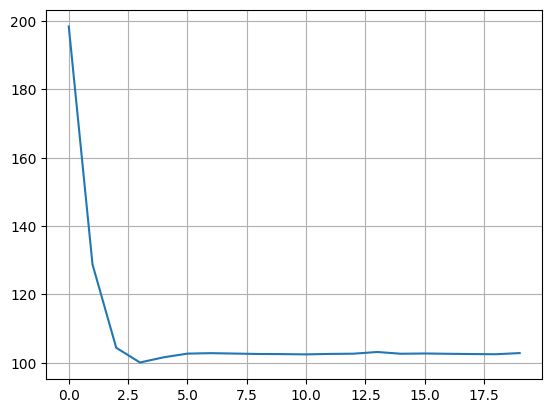

In [42]:
import matplotlib.pyplot as plt

print(len(loss_list))
plt.plot(loss_list)
plt.grid(True)
plt.show()